# Experiment Analysis

In [1]:
# Imports:

import os
import sys

sys.path.append(os.path.join("..", "code"))

from experiment_analysis import ExperimentAnalysis

In [2]:
exp_analysis = ExperimentAnalysis()

In [3]:
exp_analysis.experiments

,dec_dense_dim,dec_embed_dim,dec_num_heads,dem_kernal,dem_strides,dropout,enc_dense_dim,enc_embed_dim,enc_num_heads,end_time,...,temp_strides,tf_board_update_freq,train_end_time,train_start_time,use_masks,val_pred_end_time,val_pred_start_time,y_col,test_pred_end_time,test_pred_start_time
id,,,,,,,,,,,,,,,,,,,,,
f8804858-d98a-4207-8f0f-ef9707f1c7cd,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-22 23:36:32,...,"(1, 1)",100,2022-11-22 23:35:57,2022-11-22 23:30:41,True,2022-11-22 23:36:24,2022-11-22 23:35:57,m3,NaT,NaT
4bfdd905-b9d8-4edc-8554-95ff4b6c9c79,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-23 04:20:08,...,"(1, 1)",100,2022-11-23 04:17:06,2022-11-23 03:54:46,True,2022-11-23 04:18:35,2022-11-23 04:17:06,m3,2022-11-23 04:20:01,2022-11-23 04:18:35
83532b8e-265d-4a2a-9882-beb8f65bb870,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-22 20:50:41,...,"(1, 1)",100,2022-11-22 20:50:01,2022-11-22 20:43:13,True,2022-11-22 20:50:33,2022-11-22 20:50:01,m3,NaT,NaT


In [4]:
merged = exp_analysis.merge_pred_and_truth("4bfdd905-b9d8-4edc-8554-95ff4b6c9c79")

In [5]:
merged

time      ft        m3        area_m  \
gage     date                                                     
11189500 2015-01-01  2015-01-01    9.96  0.282036  1.371157e+09   
         2015-01-02  2015-01-02   11.00  0.311485  1.371157e+09   
         2015-01-03  2015-01-03   11.40  0.322812  1.371157e+09   
         2015-01-04  2015-01-04   11.50  0.325644  1.371157e+09   
         2015-01-05  2015-01-05   11.10  0.314317  1.371157e+09   
...                         ...     ...       ...           ...   
11402000 2016-01-10  2016-01-10   76.00  2.152080  4.743901e+08   
         2016-01-11  2016-01-11   71.80  2.033150  4.743901e+08   
         2016-01-12  2016-01-12   69.40  1.965189  4.743901e+08   
         2016-01-13  2016-01-13  195.00  5.521785  4.743901e+08   
         2016-01-14  2016-01-14  317.00  8.976440  4.743901e+08   

                     ft_per_area_m      area_km  ft_per_area_km  area_miles  \
gage     date                                                                 
11189500 2015-01-01   7.263936e-09  1371.157491        0.007264  529.406650   
         2015-01-02   8.022419e-09  1371.157491        0.008022  529.406650   
         2015-01-03   8.314143e-09  1371.157491        0.008314  529.406650   
         2015-01-04   8.387074e-09  1371.157491        0.008387  529.406650   
         2015-01-05   8.095350e-09  1371.157491        0.008095  529.406650   
...                            ...          ...             ...         ...   
11402000 2016-01-10   1.602057e-07   474.390081        0.160206  183.162959   
         2016-01-11   1.513522e-07   474.390081        0.151352  183.162959   
         2016-01-12   1.462931e-07   474.390081        0.146293  183.162959   
         2016-01-13   4.110541e-07   474.390081        0.411054  183.162959   
         2016-01-14   6.682265e-07   474.390081        0.668226  183.162959   

                     ft_per_area_miles  m3_per_area_m  ...  y_day_5_aligned  \
gage     date                                          ...                    
11189500 2015-01-01           0.018814   2.056918e-10  ...              NaN   
         2015-01-02           0.020778   2.271696e-10  ...              NaN   
         2015-01-03           0.021534   2.354303e-10  ...              NaN   
         2015-01-04           0.021722   2.374955e-10  ...              NaN   
         2015-01-05           0.020967   2.292348e-10  ...              NaN   
...                                ...            ...  ...              ...   
11402000 2016-01-10           0.414931   4.536521e-09  ...              NaN   
         2016-01-11           0.392001   4.285818e-09  ...              NaN   
         2016-01-12           0.378898   4.142560e-09  ...              NaN   
         2016-01-13           1.064626   1.163976e-08  ...              NaN   
         2016-01-14           1.730699   1.892207e-08  ...              NaN   

                     y_day_6_aligned  y_day_7_aligned  y_day_8_aligned  \
gage     date                                                            
11189500 2015-01-01              NaN              NaN              NaN   
         2015-01-02              NaN              NaN              NaN   
         2015-01-03              NaN              NaN              NaN   
         2015-01-04              NaN              NaN              NaN   
         2015-01-05              NaN              NaN              NaN   
...                              ...              ...              ...   
11402000 2016-01-10              NaN              NaN              NaN   
         2016-01-11              NaN              NaN              NaN   
         2016-01-12              NaN              NaN              NaN   
         2016-01-13              NaN              NaN              NaN   
         2016-01-14              NaN              NaN              NaN   

                     y_day_9_aligned  y_day_10_aligned  y_day_11_aligned  \
gage     date                                               

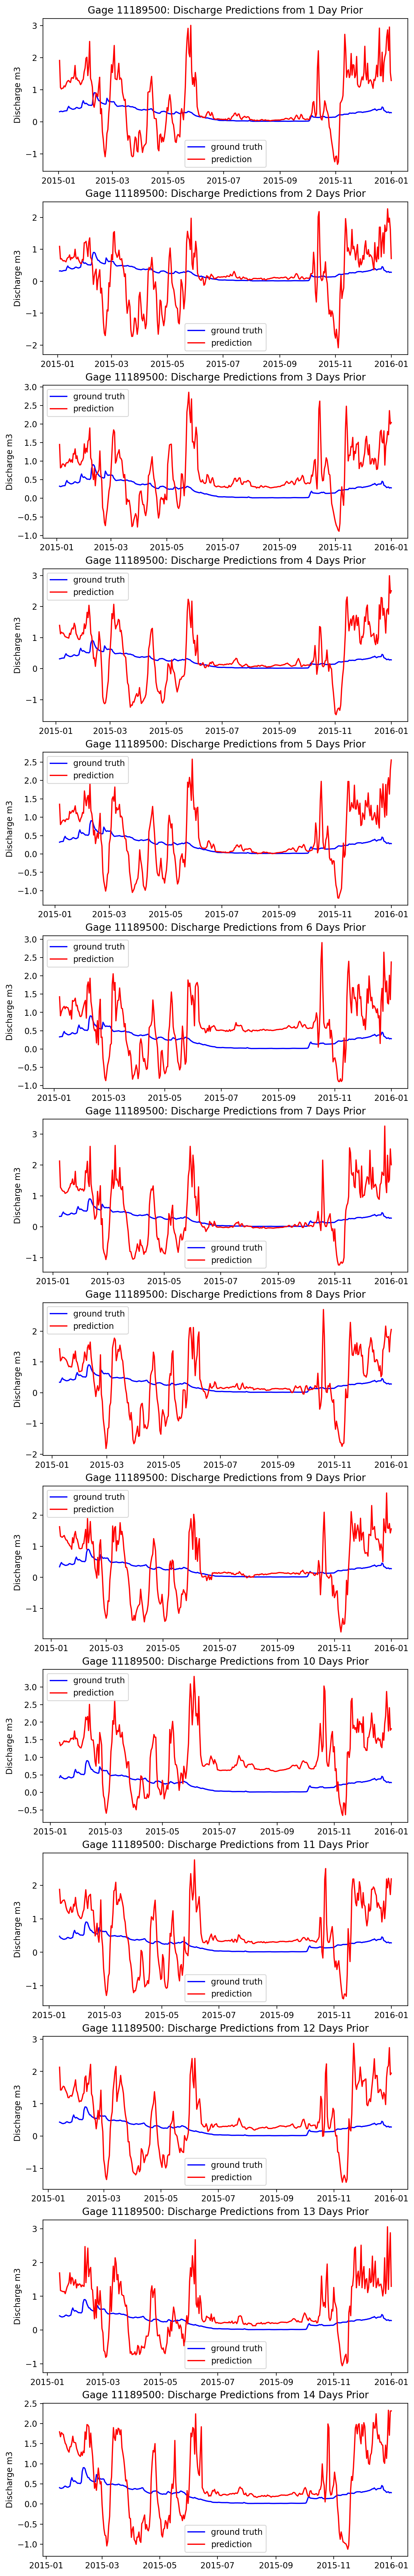

In [6]:
exp_analysis.plot_pred_vs_true(merged, "11189500", days=list(range(1, 15, 1)))

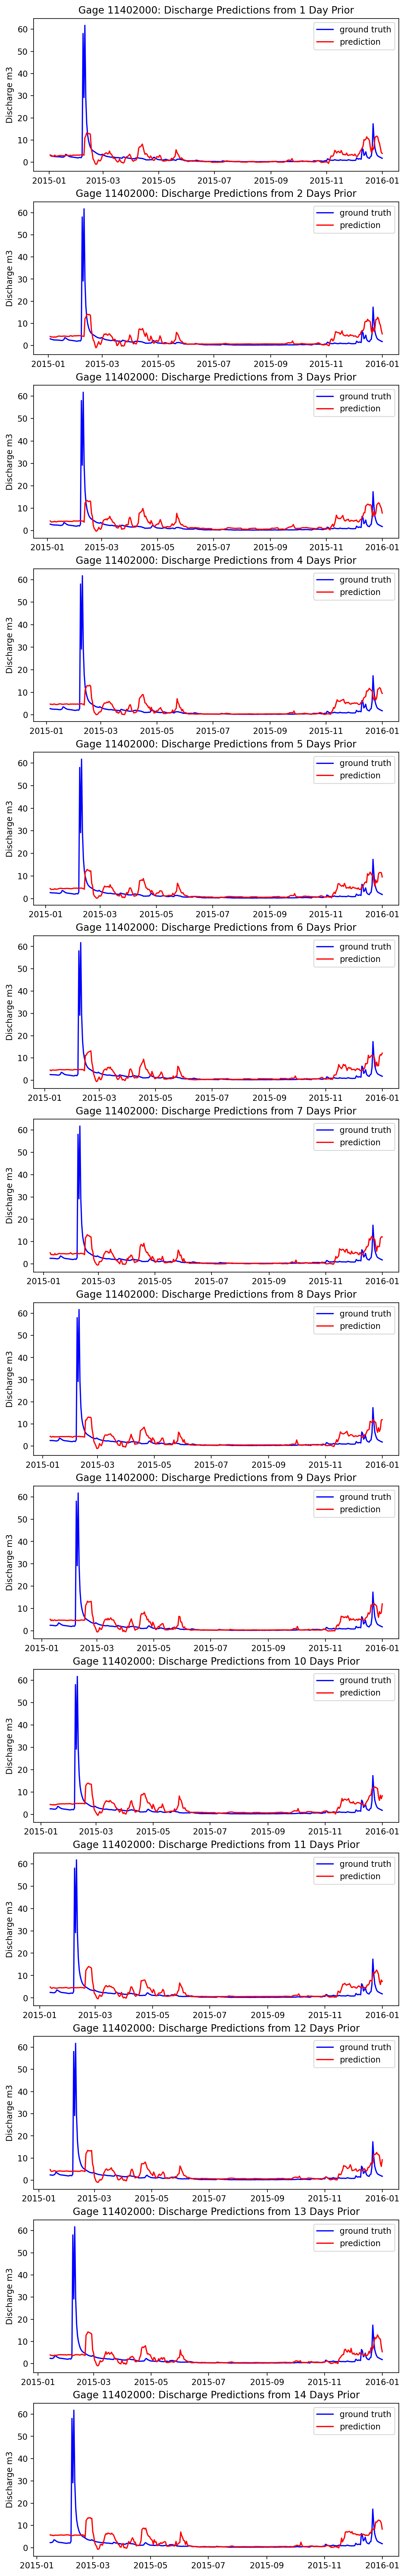

In [7]:
exp_analysis.plot_pred_vs_true(merged, "11402000", days=list(range(1, 15, 1)))

In [8]:
exp_analysis.compute_rmse_results()

Results saved to:
  /tf/toby/discharge-estimation/experiments/rmse_results.csv


,dec_dense_dim,dec_embed_dim,dec_num_heads,dem_kernal,dem_strides,dropout,enc_dense_dim,enc_embed_dim,enc_num_heads,end_time,...,rmse_5day,rmse_6day,rmse_7day,rmse_8day,rmse_9day,rmse_10day,rmse_11day,rmse_12day,rmse_13day,rmse_14day
id,,,,,,,,,,,,,,,,,,,,,
f8804858-d98a-4207-8f0f-ef9707f1c7cd,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-22 23:36:32,...,1.407598,1.438335,1.329041,1.467200,1.484628,1.470000,1.490330,1.497216,1.616453,1.402544
4bfdd905-b9d8-4edc-8554-95ff4b6c9c79,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-23 04:20:08,...,3.768852,3.783187,3.824686,3.822021,3.845173,3.945976,3.868188,3.921602,3.915542,3.930086
83532b8e-265d-4a2a-9882-beb8f65bb870,32,16,2,"(5, 5)","(1, 1)",0.5,32,16,2,2022-11-22 20:50:41,...,5.356459,5.356513,5.246464,5.370819,5.378328,5.461016,5.430082,5.438537,5.516186,5.324284
